In [1]:
# Import all necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for EDA
from sklearn import metrics # f1 score should be used for accuracy check
import os # directory and filenames traversal
import torch # construct model
from transformers import * #import the base bert model from here
import missingno # analyze NaN values in the dataset
import string # seperate the punctuation for a proper tokenization
from collections import defaultdict
# Text manipulation and tokenization
from nltk.corpus import stopwords 
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns # data analysis
import re # regular expressions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, Activation
from keras.initializers import Constant
from keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import time
import datetime
import tensorflow as tf

Using TensorFlow backend.


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('There are {} GPU(s) available'.format(torch.cuda.device_count()))
    print('The GPU {} us used'.format(torch.cuda.get_device_name(0)))
else:
    print('No GPU detected, using CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available
The GPU Tesla P100-PCIE-16GB us used


# Import data

In [3]:
# Initialize an array for file pathsbc
file_paths = list()
for dirname, _, filenames in os.walk('/kaggle/input/nlp-getting-started'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        file_paths.append(file_path)
        print(file_path)

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [4]:
file_paths

['/kaggle/input/nlp-getting-started/sample_submission.csv',
 '/kaggle/input/nlp-getting-started/test.csv',
 '/kaggle/input/nlp-getting-started/train.csv']

In [5]:
# Set csv files
train_file = file_paths[2]
test_file = file_paths[1]
samples_file = file_paths[0]

In [6]:
# Set train and test data
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
samples_df = pd.read_csv(samples_file)

# Imformation about the data

In [7]:
print("The training set has {} rows with {} input features".format(train_df.shape[0], train_df.shape[1] - 2))
print("The test set has {} rows".format(test_df.shape[0]))

The training set has 7613 rows with 3 input features
The test set has 3263 rows


In [8]:
# Train dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Test dataset
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# Samples dataset. That's how we need to submit the answer
samples_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


It will be helpful to take a look at some tweets in the train dataset.

In [11]:
# Show first 20 tweets
pd.options.display.max_colwidth=200
train_df['text'].apply(lambda x: x.strip().split())
print(train_df['text'][:20])

0                                                                     Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                    Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                         13,000 people receive #wildfires evacuation orders in California 
4                                                  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5                            #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6                                           #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7                   

Let's take a look on proportion of each tweet to understand whether cross validation is needed or not and also get the class distribution for further feature engneering.

In [12]:
# Get each the number of people from each class
real_length = train_df[train_df["target"] == 1].shape[0]
fake_length = train_df[train_df["target"] == 0].shape[0]

<function matplotlib.pyplot.show(*args, **kw)>

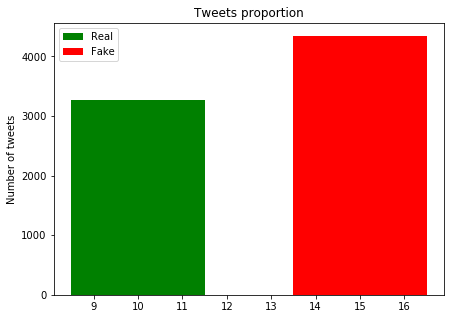

In [13]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10, real_length, 3, label="Real", color='green')
plt.bar(15, fake_length, 3, label="Fake", color='red')
plt.legend()
plt.ylabel('Number of tweets')
plt.title('Tweets proportion')
plt.show

As we can see from above, the train dataset (the test dataset as well) has NaN values for 2 features. Let's analyze how bad the situation is. It will help us in the further steps. We will use 

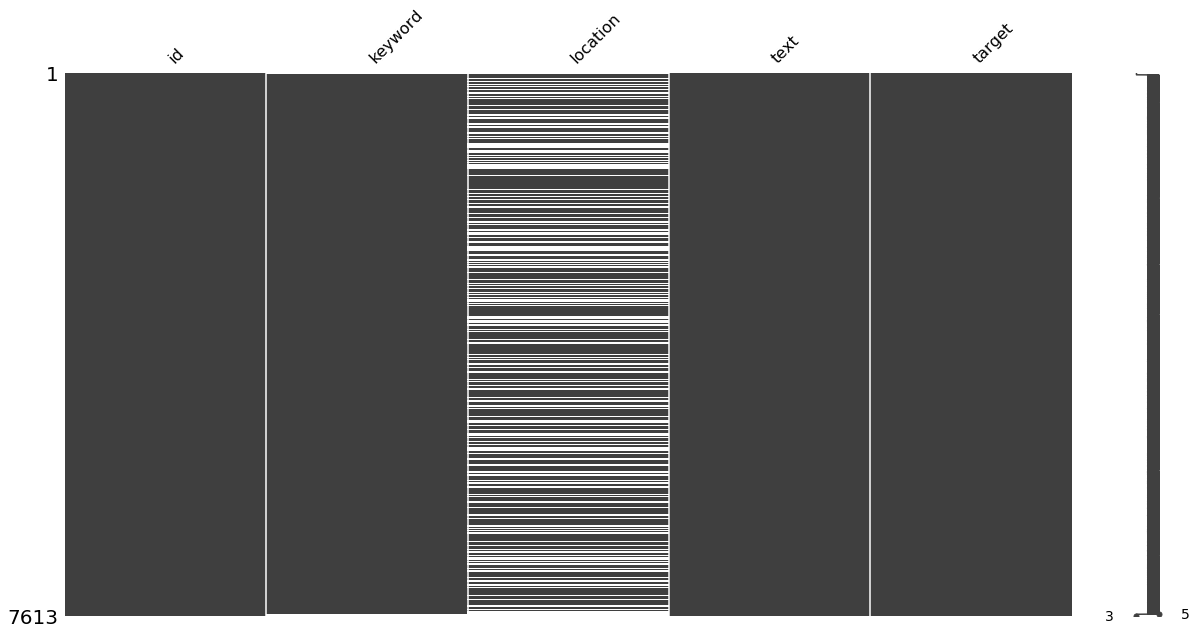

In [14]:
missingno.matrix(train_df, figsize=(20, 10))

Okay, as we see, the "location" feature has many NaN values and because of it's type (it's categorical feature), it won't be effective to fill NaN values with some data and that is why it would be logical if we will drop that feature out. But let's not hurry and take a look on a test dataset too and understand what is the situation there.

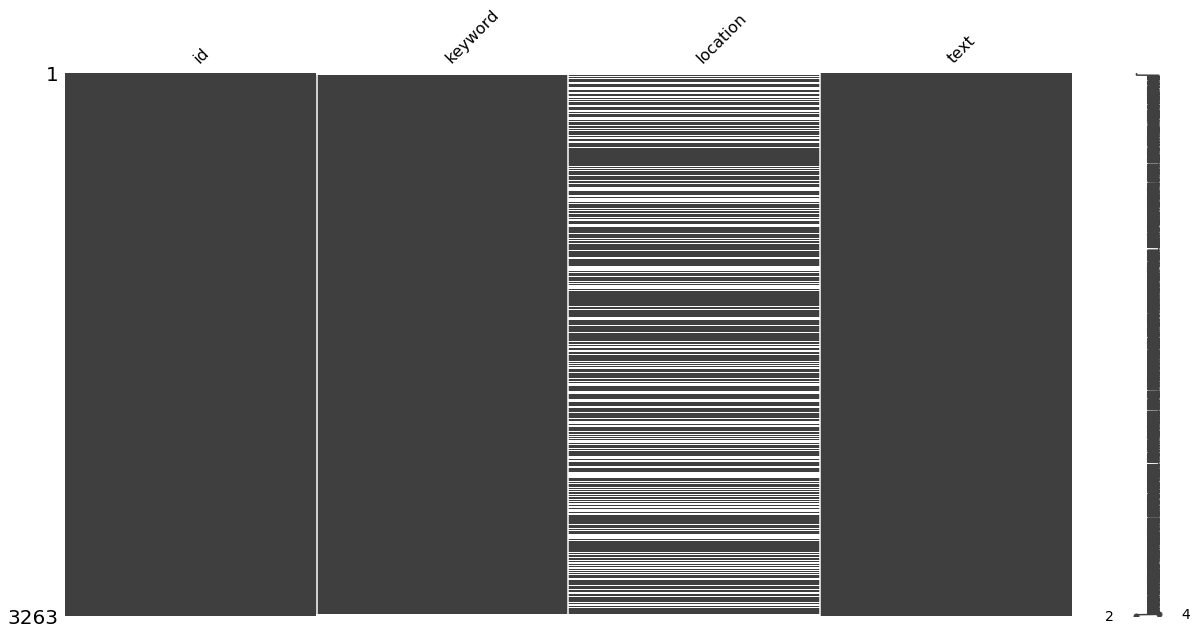

In [15]:
missingno.matrix(test_df, figsize=(20, 10))

We can see the similiar picture on location feature, that's why we won't drop that feature out because in our case it seems that the location makes sense as a feature but if it is not, then we can leave that there, so our model can learn on NaN locations as well (e.g. the location is not given).

It will be a good idea to take a look at the classes' distributions to understand whether it's possible to find some connection between them. As a y label we will consider the number of characters in tweets. If we look at some tweets in the dataset itself, we can figure out, that the real accident tweets generally contain more imformation about the accident itself, consequently more characters should be used. On the other hand, fake accident tweets contain less imformation about the accident because in most cases there are some morphological meanings in tweets and there is no need to provide more imformation. So we can assume that the number of characters in tweets is a good feature. Let's add it to our train dataset.

In [16]:
def length(text):
    text = text.replace(" ", "")
    return len(text)

In [17]:
train_df['length'] = train_df['text'].apply(length)

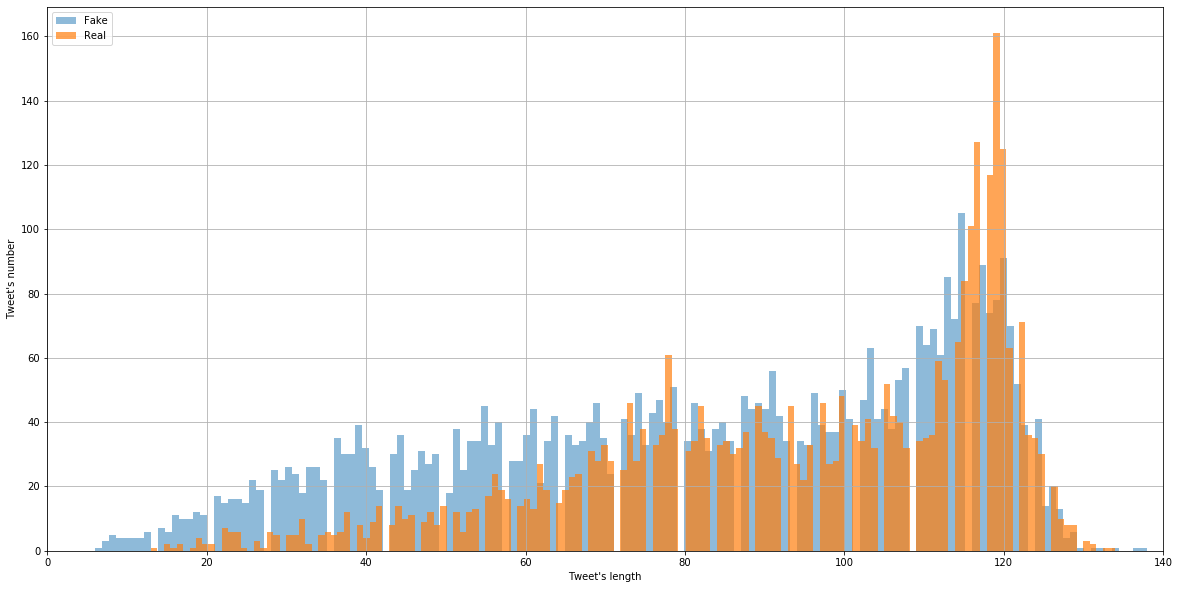

In [18]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.hist(train_df[train_df['target'] == 0]['length'], alpha = 0.5, bins=150, label='Fake')
plt.hist(train_df[train_df['target'] == 1]['length'], alpha = 0.7, bins=150, label='Real')
plt.xlabel('Tweet\'s length')
plt.ylabel('Tweet\'s number')
plt.legend(loc='upper left')
plt.xlim(0, 140)
plt.grid()
plt.show()

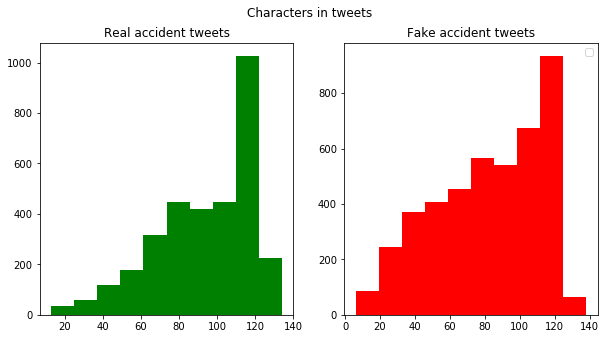

In [19]:
fig, (x1, x2) = plt.subplots(1, 2, figsize=(10, 5))
x1.hist(train_df[train_df['target'] == 1]['text'].apply(length), color='green')
x2.hist(train_df[train_df['target'] == 0]['text'].apply(length), color='red')
x1.set_title('Real accident tweets')
x2.set_title('Fake accident tweets')
fig.suptitle('Characters in tweets')
plt.legend()
plt.show()

From histograms we can see that from 110 to 120 characters sentences are most common ones in both cases.

The next common thing that we take a look at, is words in our sentence. To be more concrete, the number of words in our sentence, which also plays a big role in deciding whether the tweet is connected to real accident or not. You can think why we are adding the number of words if we just added the number of characters. It will be a logical question. If we look at the 20th sentence in out train dataset above (What a gooooooooooaaaaaaaaal!!!!), we can see many characters but just 3 words. So why we just don't delete the characters number and leave only the number of words? The answer is simple. Because on character level we have more semantics hidden, that we can't ignore, but to avoid situations that I mentioned above we need to monitor the number of words too.

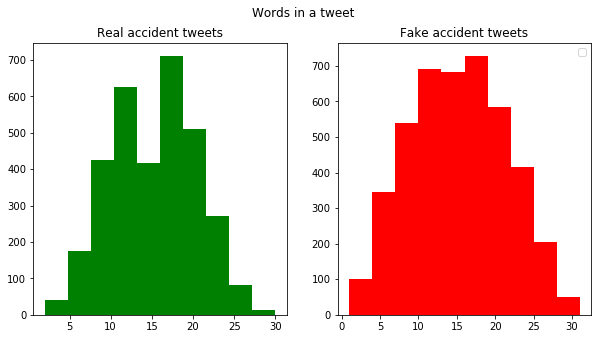

In [20]:
fig, (x1, x2) = plt.subplots(1, 2, figsize=(10, 5))
length = train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
x1.hist(length, color='green')
x1.set_title('Real accident tweets')
length = train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
x2.hist(length, color='red')
x2.set_title('Fake accident tweets')
fig.suptitle('Words in a tweet')
plt.legend()
plt.show()

The most common number of words is between 17 and 20 for both classes

In [21]:
train_df['Number of words'] = train_df['text'].apply(lambda x: len(x.split()))

Let's think a little about our sentences and what do they contain. Maybe there is an additional imformation that interefers us to train our model well, or maybe some data that will make our model overfitting and worse, something interfers us to get a good analysis of our sentences. Because we are examining tweets, it is possible, that people leave hashtags, misspell words, add urls etc. Let's list them.
1. Urls
2. Hashtags
3. Misspelling
4. Abbreviations
5. Emojies

Each of these points won't let us to make a proper analysis of our text. Don't forget, that we are going to feed it to the Bert model, which was learnt via Wikipedia and English books. Punctuational and misspelling errors will ruin the model prediction. I saw some people deleted the punctuation as well․ I guess the problem is in tokenization, but it's also can be solved via adding a space before and after each punctuation not to ruin the tokenization. I guess that in the case of BERT it is better to leave punctuations because they also have some semantic meaning and BERT has learnt these semantics as well.

So before training our model, we need to update our tweets and make some manipulation on them to make our model run effectively,

In [22]:
# Set space before and after each punctuation
def seperate_punctuation(text):
    for x in string.punctuation:
        text = text.replace(x, str(' ' + x + ' '))
    return text

In [23]:
train_df['text'] = train_df['text'].apply(seperate_punctuation)
# test_df['text'] = test_df['text'].apply(seperate_punctuation)
train_df['text'][:2]

0    Our Deeds are the Reason of this  # earthquake May ALLAH Forgive us all
1                                   Forest fire near La Ronge Sask .  Canada
Name: text, dtype: object

In [24]:
# Create corpus function
def create_corpus(data, target):
    corpus = []
    for x in data[data['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Let's do a bigram analysis to understand which words are the most common ones and understand which manipulations we need. 

In [25]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

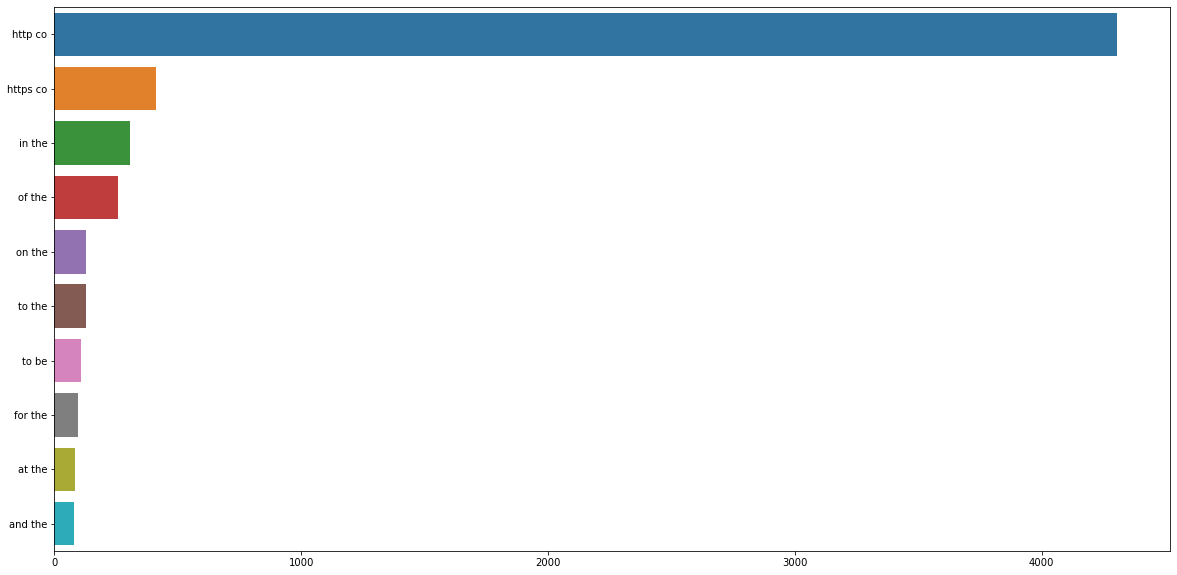

In [26]:
plt.figure(figsize=(20, 10))
top_bigrams = get_top_bigrams(train_df['text'])[:10]
x, y = map(list, zip(*top_bigrams))
sns.barplot(x=y, y=x)

As we can see, http co is the first bigram and it's not good because that bigram doesn't contain any information whether the accident was real or not but we can see it in our text often.

## Remove URLs

In [27]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [28]:
train_df['text'] = train_df['text'].apply(lambda x: remove_url(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_url(x))

## Remove HTML tags

In [29]:
def remove_html(text):
    html= re.compile(r'<.*?>')
    return html.sub(r'', text)

In [30]:
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

## Remove Emojis

In [31]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [32]:
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_emoji(x))

## Open abbreviations
Many tweets include abbreviations because of peoples' laziness to write the whole thing. That's why we need to open as many abbreviations as possible, to make our model more effective

In [33]:
# Visit https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

There are more abbreviations but it seems that I am too lazy to write more.)

In [34]:
def open_abbreviations(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [35]:
def open_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [open_abbreviations(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [36]:
train_df['text'] = train_df['text'].apply(open_abbrev_in_text)
test_df['text'] = test_df['text'].apply(open_abbrev_in_text)

## Spell checking
In tweets many people don't care about the correctness of words, that they are texting because they know that others will understand what do they mean. That is why we need to make spellchecking. For that Python provides a $\textit{pyspellchecker}$ library.

In [ ]:
!pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    words = text.split()
    misspelled_words = spell.unknown(words)
    for word in words:
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
train_df['text'] = train_df['text'].apply(correct_spellings)
test_df['text'] = train_df['text'].apply(correct_spellings)

# GLOVE
For word embeddings we will use GLOVE. We will use 200d representation.

In [ ]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

To tokenize the words of the text, we need to know all the words in both train and test samples, so we will create a concatenated dataset of train and test data.

In [ ]:
df = pd.concat([train_df, test_df])
df.head()

In [ ]:
corpus = create_corpus_new(df)

In [ ]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences=tokenizer.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen=50, truncating='post', padding='post')

word_index = tokenizer.word_index
print('Unique words\' number: {}'.format(len(word_index)))

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

# Base models' performance
For a base model we will pick up an LSTM․

In [ ]:
model = Sequential()
embedding = Embedding(num_words, 200, embeddings_initializer=Constant(embedding_matrix), input_length=50,trainable=False)
model.add(embedding)
model.add(LSTM(200, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
optimizer=Adam(learning_rate=3e-5)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
train=tweet_pad[:train_df.shape[0]]
test=tweet_pad[train_df.shape[0]:]
X_train,X_test,y_train,y_test=train_test_split(train, train_df['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

The baseline model achieves 79% accuracy on the 20% of the train data if the 80% of the data is used for the training.

# Model import
We will use the basic BERT (12 layers) model for sequence classification. Cause training the model itself is computationally very expensive, we will import a ready model from $\textit{transformers}$ package 

In [38]:
# Load the BERT classifier
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False,)
model = model.to(device)

# Tokenization
We will use a ready BERT tokenizer from $\textit{transformers}$ package

In [39]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [40]:
# Test the tokenizer
sample_sentence = train_df['text'][0]
print('The sample sentence is: {}\n'.format(sample_sentence))
print('The tokenized sequence is: {}\n'.format(tokenizer.tokenize(sample_sentence)))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample_sentence)))

The sample sentence is: Our Deeds are the Reason of this # earthquake May ALLAH Forgive us all

The tokenized sequence is: ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']

Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [41]:
# Tokenize all the sentences in the dataset
input_ids = []
attention_masks = []

sentences = train_df.text.values
labels = train_df.target.values


for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=100,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
print(input_ids.shape, attention_masks.shape)
labels = torch.tensor(labels)

# Test the tokenization
print('The sample sentence: {}\n'.format(sample_sentence))
print('Token IDs: ', input_ids[0])
train_df.text.values

torch.Size([7613, 100]) torch.Size([7613, 100])
The sample sentence: Our Deeds are the Reason of this # earthquake May ALLAH Forgive us all

Token IDs:  tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


array(['Our Deeds are the Reason of this # earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask . Canada',
       "All residents asked to ' shelter in place ' are being notified by officers . No other evacuation or shelter in place orders are expected",
       ...,
       'M1 . 94 [ 01 : 04 coordinated universal time ] ? 5km S of Volcano Hawaii . http : / / t . co / zDtoyd8EbJ',
       'Police investigating after an e - bike collided with a car in Little Portugal . E - bike rider suffered serious non - life threatening injuries .',
       'The Latest : More Homes Razed by Northern California Wildfire - ABC News http : / / t . co / YmY4rSkQ3d'],
      dtype=object)

## Training and Validation
We will divide our training data to use 90% for training and 10% for validation.

In [42]:
# Combine all the data into TensorDataSet
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

6851 training samples
762 validation samples


In the BERT paper for fine-tuning authors recommend using the following values for each of hyperparameters:
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [43]:
# Hyperparameter tuning.
batch_size = 1000
lr=5e-5
eps=1e-8
epochs=3

# combining dataset in dataloader to save a memory and for comfortable batching
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

In [44]:
def accuracy(preds, labels):
    preds = np.argmax(preds, axis=1)
    labels = labels.flatten()
    return np.sum(preds == labels)/len(labels)

# Training
We will use an Adam optimizer with fine-tuned parameters and the learning rate scheduler to achieve a higher accuracy and to avoid the exploiding gradient problem in our training.

In [45]:
# Set an optimizer from the package (not from pytorch)
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

# Set training steps
total_steps = len(train_dataloader) * epochs

# Set the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [46]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [48]:
print("\n====== Epoch 1 / 3 =======")
print("Training...")
print("\nAverage training loss: 0.5045")
print("\n====== Epoch 1 / 3 =======")
# Training loop
for epoch in range(1, epochs + 1):
    print("\n====== Epoch {:} / {:} =======".format(epoch, epochs))
    print('Training...')
    start_time = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch_input_ids = batch[0].to(device)
        batch_input_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)
        model.zero_grad()
        loss, logits  = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels = batch_labels)
        total_train_loss+= loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    average_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - start_time)
    print("\nAverage training loss: {}".format(average_loss))


====== Epoch 1 / 3 =======
Training...

Average training loss: 0.5045

====== Epoch 1 / 3 =======
Training...

Average training loss: 0.3257

====== Epoch 1 / 3 =======
Training...

Average training loss: 0.2457


In [49]:
# Validation loop
print("\nRunning validation...")
start_time = time.time()
model.eval()
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

for batch in val_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_input_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)
    with torch.no_grad():
        (loss, logits) = model(batch_input_ids, token_type_ids=None, attention_mask=batch_input_mask, labels=batch_labels)
    total_eval_loss += loss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    total_eval_accuracy = accuracy(logits, label_ids)
    print(total_eval_accuracy)
average_value_accuracy = total_eval_accuracy / len(val_dataloader)
average_value_loss = total_eval_loss / len(val_dataloader)
validation_time = format_time(time.time() - start_time)
print("Accuracy: {}".format(average_value_accuracy))
print("Validation Loss: {}".format(average_value_loss))


Running validation...
Accuracy: 0.8412
Validation Loss: 0.2567


As we can see, we get a 84% accuracy, which is an expected accuracy for BERT classification task.

# Conclusion

We have analyzed the data, made some manipulations with data to effectively fit the sentences into our model and achieve better accuracy in our models. Firstly, we have tried to use a baseline model - LSTM and achieved 79% accuracy. Then we have tried a pretrained BERT model and trained it via batches with decreasing learning rate to achieve a higer accuracy. The accuracy we achieved after using a hypertuning is 84%.